# Regresión Logística
---

In [2]:
library(epiR)
library(tidyverse)
library(ggplot2)
library(readxl)
library(GGally) # para matriz de graficos
library(ResourceSelection) # para test H-L
library(DescTools) # para seudos R2

In [13]:
# lineas para limpieza
rm(list=ls())

## Factores de riesgo

* RR: Riesgo Relativo: compara la incidencia entre los que tienen factor de riesgo y quienen no lo tienen
* OR: Odds ratio ("chance de", "razón de chance", "oportunidad relativa"): compara chances de los que tienen factores vs lo que no

---
* E (variable objetivo / dependiente): Bajo Peso (BP SI, BP NO)
* F (factor / var independiente) : Tabaquismo madre (T SI, T NO)

In [10]:
tabla1 <- array(c(136, 177, 225, 2216), dim = c(2,2))
colnames(tabla1) <- c("BP+", "BP-")
rownames(tabla1) <- c("T+", "T-")
tabla1

,BP+,BP-
T+,136,225
T-,177,2216


In [11]:
tot <- sum(tabla1)         # total de casos
BP <- sum(tabla1[,1])      # suma col 1 = total de casos con bajo peso
tabaq <- sum(tabla1[1,])   # suma de la fila 1 = total de casos de tabaquismo en los datos 
NOtabaq <- sum(tabla1[2,]) # suma de la fila 2 = total de casos de no tabaquismo
BP / tot                   # prevalencia de bajo peso (11%)

[1] 0.1136529

In [6]:
margin.table(tabla1, 1)      # totales frecuencias fila  
margin.table(tabla1, 2)      # totales frecuencias columna
round(prop.table(tabla1), 3) # proporciones del total, redondeo 2 decimales

T+   T- 
 361 2393

BP+  BP- 
 313 2441

,BP+,BP-
T+,0.049,0.082
T-,0.064,0.805


In [13]:
# riesgo relativo de bajo peso al nacer
# Si RR = 1 no hay riesgo
(tabla1[1,1]/tabaq)/(tabla1[2,1]/NOtabaq) 

[1] 5.093322

In [14]:
# ODD RATIO
# Chance de bajo peso si fuma vs. si no fuma
# Si OR = 1, F no representa riesgo
# Si OR > 1, F factor dañino
# Si OR < 1, F factor de protección
(tabla1[1,1]/tabla1[1,2])/(tabla1[2,1]/tabla1[2,2])

[1] 7.567508

In [9]:
epi.2by2(tabla1,"case.control") #OJO! para interpretar RR hay que ordenar la tabla para que (+) estén izq-arriba 

             Outcome+    Outcome-      Total                 Odds
Exposed +         136         225        361  0.60 (0.49 to 0.74)
Exposed -         177        2216       2393  0.08 (0.07 to 0.09)
Total             313        2441       2754  0.13 (0.11 to 0.14)

Point estimates and 95% CIs:
-------------------------------------------------------------------
Exposure odds ratio                            7.57 (5.82, 9.84)
Attrib fraction (est) in the exposed (%)      86.79 (82.82, 89.83)
Attrib fraction (est) in the population (%)   37.71 (35.84, 40.31)
-------------------------------------------------------------------
Uncorrected chi2 test that OR = 1: chi2(1) = 285.440 Pr>chi2 = <0.001
Fisher exact test that OR = 1: Pr>chi2 = <0.001
 Wald confidence limits
 CI: confidence interval 

## Regresión Logísitica Simple

### Ejemplo Incidencia Cardíaca (Libro de Hosmer y Lemeshow)

In [19]:
setwd("/Users/ppando/Materias/data/materias/aprendizaje-automatico/bd")
dataHL <- read_excel("HL-ejemplo1.xls")
# dataHL <- as.data.frame(dataHL)
# dataHL <- na.omit(dataHL)

summary(dataHL)

       ID              AGE             AGRP           CHD      
 Min.   :  1.00   Min.   :20.00   Min.   :1.00   Min.   :0.00  
 1st Qu.: 25.75   1st Qu.:34.75   1st Qu.:2.75   1st Qu.:0.00  
 Median : 50.50   Median :44.00   Median :4.00   Median :0.00  
 Mean   : 50.50   Mean   :44.38   Mean   :4.48   Mean   :0.43  
 3rd Qu.: 75.25   3rd Qu.:55.00   3rd Qu.:7.00   3rd Qu.:1.00  
 Max.   :100.00   Max.   :69.00   Max.   :8.00   Max.   :1.00  

* Y = CHD (variable respuesta dicotómica)
    * 1 si presentó incidente cardíaco
    * 0 si no
* X = AGE

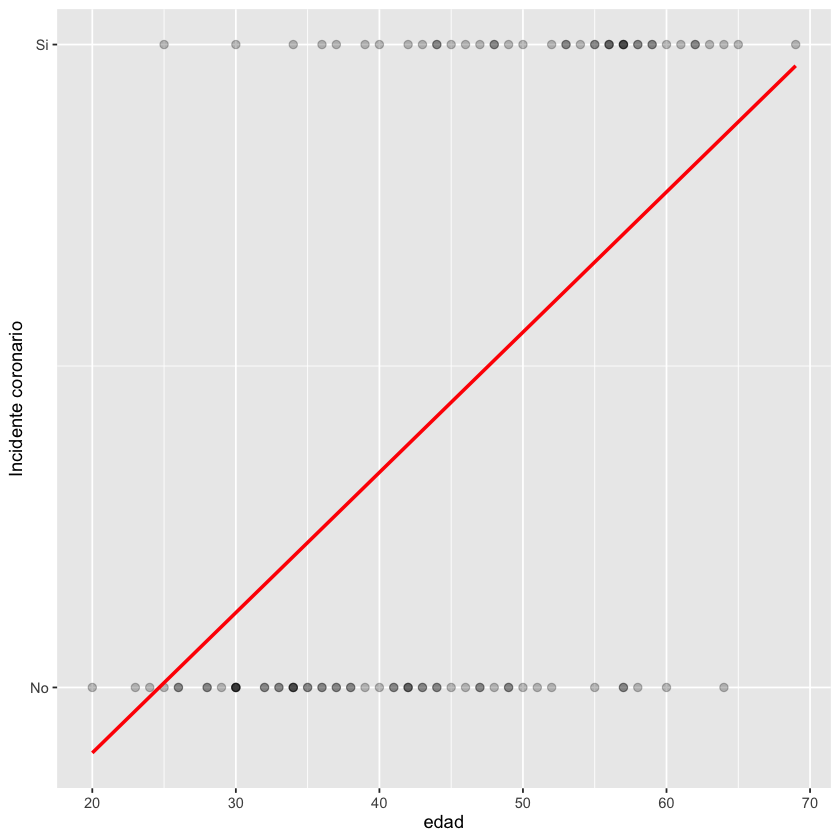

In [18]:
# grafiquemos los datos
ggplot(data = dataHL, aes(x = AGE, y = CHD)) +
  geom_point(alpha = 0.25, size = 2) +
  geom_smooth(method = "lm", formula = 'y ~ x', se = FALSE, color = "red") +
  scale_y_continuous(breaks = c(0, 1), labels = c("No", "Si")) +
  labs(x = "edad", y = "Incidente coronario")

In [21]:
# ajuste de reg logistica simple
dataHL$CHD <- as.factor(dataHL$CHD)
modeloHL <- glm(CHD ~ AGE, data = dataHL, family = binomial())
summary(modeloHL)


Call:
glm(formula = CHD ~ AGE, family = binomial(), data = dataHL)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.30945    1.13365  -4.683 2.82e-06 ***
AGE          0.11092    0.02406   4.610 4.02e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 136.66  on 99  degrees of freedom
Residual deviance: 107.35  on 98  degrees of freedom
AIC: 111.35

Number of Fisher Scoring iterations: 4


* Se propone modelar las probabilidades condicionales mediante una función logística

$$\pi(x) = P(Y = 1/x) = \dfrac{e^{\beta_0 + \beta_1x}}{1 + e^{\beta_0 + \beta_1x}}$$

* Probabilidad de Y=1 según sea el valor de "x"

### Ejemplo Demencia2: wine de 2 clases

In [52]:
dataD <- read_excel("demencia2.xls")
#dataD <- as.data.frame(dataD)
summary(dataD)

       ID              AGE             WINE             MMSE     
 Min.   :  1.00   Min.   :64.75   Min.   :0.0000   Min.   : 0.0  
 1st Qu.: 68.75   1st Qu.:69.04   1st Qu.:0.0000   1st Qu.:23.0  
 Median :136.50   Median :75.58   Median :1.0000   Median :26.0  
 Mean   :136.50   Mean   :75.22   Mean   :0.5184   Mean   :25.3  
 3rd Qu.:204.25   3rd Qu.:79.54   3rd Qu.:1.0000   3rd Qu.:28.0  
 Max.   :272.00   Max.   :91.42   Max.   :1.0000   Max.   :30.0  
     HIGHBP         T3DEMEN      
 Min.   :0.000   Min.   :0.0000  
 1st Qu.:0.000   1st Qu.:0.0000  
 Median :0.000   Median :0.0000  
 Mean   :0.136   Mean   :0.2647  
 3rd Qu.:0.000   3rd Qu.:1.0000  
 Max.   :1.000   Max.   :1.0000  

In [53]:
str(dataD)

tibble [272 × 6] (S3: tbl_df/tbl/data.frame)
 $ ID     : num [1:272] 1 2 3 4 5 6 7 8 9 10 ...
 $ AGE    : num [1:272] 69.7 67.3 81.9 66.9 73.9 ...
 $ WINE   : num [1:272] 0 0 0 0 0 0 0 0 0 0 ...
 $ MMSE   : num [1:272] 28 29 29 25 27 28 23 26 27 27 ...
 $ HIGHBP : num [1:272] 0 0 0 0 0 0 0 1 0 0 ...
 $ T3DEMEN: num [1:272] 0 0 0 0 0 0 0 0 0 1 ...


In [54]:
dataD$WINE<-as.factor(dataD$WINE)
dataD$HIGHBP<-as.factor(dataD$HIGHBP)
dataD$T3DEMEN<-as.factor(dataD$T3DEMEN) 
summary(dataD)

       ID              AGE        WINE         MMSE      HIGHBP  T3DEMEN
 Min.   :  1.00   Min.   :64.75   0:131   Min.   : 0.0   0:235   0:200  
 1st Qu.: 68.75   1st Qu.:69.04   1:141   1st Qu.:23.0   1: 37   1: 72  
 Median :136.50   Median :75.58           Median :26.0                  
 Mean   :136.50   Mean   :75.22           Mean   :25.3                  
 3rd Qu.:204.25   3rd Qu.:79.54           3rd Qu.:28.0                  
 Max.   :272.00   Max.   :91.42           Max.   :30.0                  

In [55]:
# Saco ID
dataD <- dataD[,-1]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


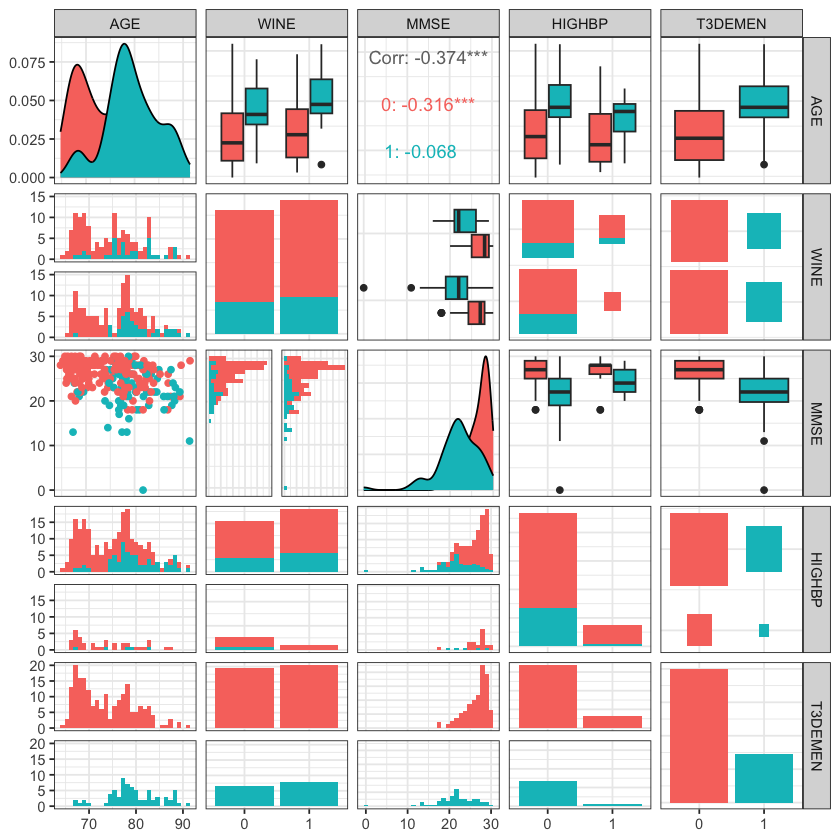

In [56]:
#puede verse a priori la relación con la v.respuesta?
ggpairs(dataD, mapping = aes(colour= T3DEMEN)) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    theme_bw()

In [57]:
# modelo logístico con una variable dummy
modeloD <- glm(T3DEMEN ~ AGE + WINE + MMSE, data = dataD, family = binomial())
summary(modeloD)


Call:
glm(formula = T3DEMEN ~ AGE + WINE + MMSE, family = binomial(), 
    data = dataD)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.85787    2.69333  -0.690    0.490    
AGE          0.11571    0.02890   4.004 6.23e-05 ***
WINE1       -0.46202    0.34957  -1.322    0.186    
MMSE        -0.31753    0.05232  -6.069 1.29e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 314.39  on 271  degrees of freedom
Residual deviance: 219.69  on 268  degrees of freedom
AIC: 227.69

Number of Fisher Scoring iterations: 5


### Análisis de Devianza

* Permite definir indicadores para comparación de modelos (AIC, BIC, etc.)
* Se utiliza para:
    * Testear la significancia del modelo (vale la pena modelar Y a partir de X1, ..., Xp?)
    * Testear la significatividad de una variable (vale la pena agregar esa variable a la que ya puse?)
    * Comparar modelos anidados en general

#### Significatividad del modelo

* H0: modelo solo con $\beta_0$ (modelo null)
* H1: modelo completo

In [61]:
# se puede ver en el summary pero hagamos "a mano":
dev_mod <-  summary(modeloD)$deviance
dev_null <- summary(modeloD)$null.deviance
pchisq(dev_null - dev_mod, lower.tail = FALSE, df=3) # df = diferencia entre cantidad de variables de ambos

[1] 2.138574e-20

* Significa rechazar la hipótesis nula (el modelo es significativo)

In [62]:
# otra forma
modelo.nulo<- glm(T3DEMEN ~ 1,data = dataD, family = binomial())
summary(modelo.nulo)
anova(modelo.nulo,modeloD,test="Chisq") #pvalor chico entonces el modeloD es significativo


Call:
glm(formula = T3DEMEN ~ 1, family = binomial(), data = dataD)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.0217     0.1374  -7.434 1.06e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 314.39  on 271  degrees of freedom
Residual deviance: 314.39  on 271  degrees of freedom
AIC: 316.39

Number of Fisher Scoring iterations: 4


,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,271,314.3895,NA,NA,NA
2,268,219.6864,3,94.70308,2.138574e-20


#### Significatividad de una variable calculada con devianza

In [64]:
modeloD2<- glm(T3DEMEN ~ AGE + MMSE, data = dataD, family = binomial())
summary(modeloD2)
dev_mod2 <- summary(modeloD2)$deviance
pchisq(dev_mod2-dev_mod, lower.tail = FALSE, df=1)  #da la significatividad de la variable wine que es la que se sacó


Call:
glm(formula = T3DEMEN ~ AGE + MMSE, family = binomial(), data = dataD)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.09432    2.70623  -0.774    0.439    
AGE          0.11235    0.02873   3.910 9.23e-05 ***
MMSE        -0.30671    0.05136  -5.972 2.34e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 314.39  on 271  degrees of freedom
Residual deviance: 221.47  on 269  degrees of freedom
AIC: 227.47

Number of Fisher Scoring iterations: 5


[1] 0.182209

In [65]:
# OTRA forma para comparar los dos modelos con deviancias:
anova(modeloD,modeloD2,test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,268,219.6864,NA,NA,NA
2,269,221.4659,-1,-1.779514,0.182209


In [66]:
# PRUEBAS DE WALD 
# la signif de cada coef que sale en summary es la de Wald.
#los intervalos de confianza de los estimados son:
confint(modeloD) #IC de Wald
exp(confint(modeloD)) #IC de Wald para los odds

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-7.15161971,3.4634743
AGE,0.06045347,0.1743382
WINE1,-1.16169171,0.2148152
MMSE,-0.42594051,-0.2199859


Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),0.0007835939,31.9277110
AGE,1.0623181652,1.1904581
WINE1,0.3129563006,1.2396328
MMSE,0.6531551956,0.8025301


In [67]:
#2) significatividad de una variable calculada con deviancia
modeloD3<- glm(T3DEMEN ~ AGE,data = dataD, family = binomial())
summary(modeloD3)
summary(modeloD)
anova(modeloD3,modeloD,test = "Chisq")


Call:
glm(formula = T3DEMEN ~ AGE, family = binomial(), data = dataD)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -12.96105    2.01031  -6.447 1.14e-10 ***
AGE           0.15595    0.02582   6.041 1.53e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 314.39  on 271  degrees of freedom
Residual deviance: 269.24  on 270  degrees of freedom
AIC: 273.24

Number of Fisher Scoring iterations: 4



Call:
glm(formula = T3DEMEN ~ AGE + WINE + MMSE, family = binomial(), 
    data = dataD)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.85787    2.69333  -0.690    0.490    
AGE          0.11571    0.02890   4.004 6.23e-05 ***
WINE1       -0.46202    0.34957  -1.322    0.186    
MMSE        -0.31753    0.05232  -6.069 1.29e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 314.39  on 271  degrees of freedom
Residual deviance: 219.69  on 268  degrees of freedom
AIC: 227.69

Number of Fisher Scoring iterations: 5


,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,270,269.2357,NA,NA,NA
2,268,219.6864,2,49.54937,1.739764e-11


#### Pruebas para evaluación del modelo

In [71]:
# Test H-L 
# H0: el modelo ajusta a los datos
# H1: el modelo no ajusta a los datos
hoslem.test(modeloD$y, fitted(modeloD)) 


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  modeloD$y, fitted(modeloD)
X-squared = 5.237, df = 8, p-value = 0.732


* pvalor grande! entonces no hay evidencia para rechazar H0

In [72]:
# Pseudo R2
PseudoR2(modeloD, c("CoxSnell", "Nagel")) #usa library(DescTools)
PseudoR2(modeloD2, c("CoxSnell", "Nagel"))

CoxSnell Nagelkerke 
 0.2940233  0.4291008

CoxSnell Nagelkerke 
 0.2893895  0.4223380

### Diagnósticos: evaluando punto influyentes y outliers

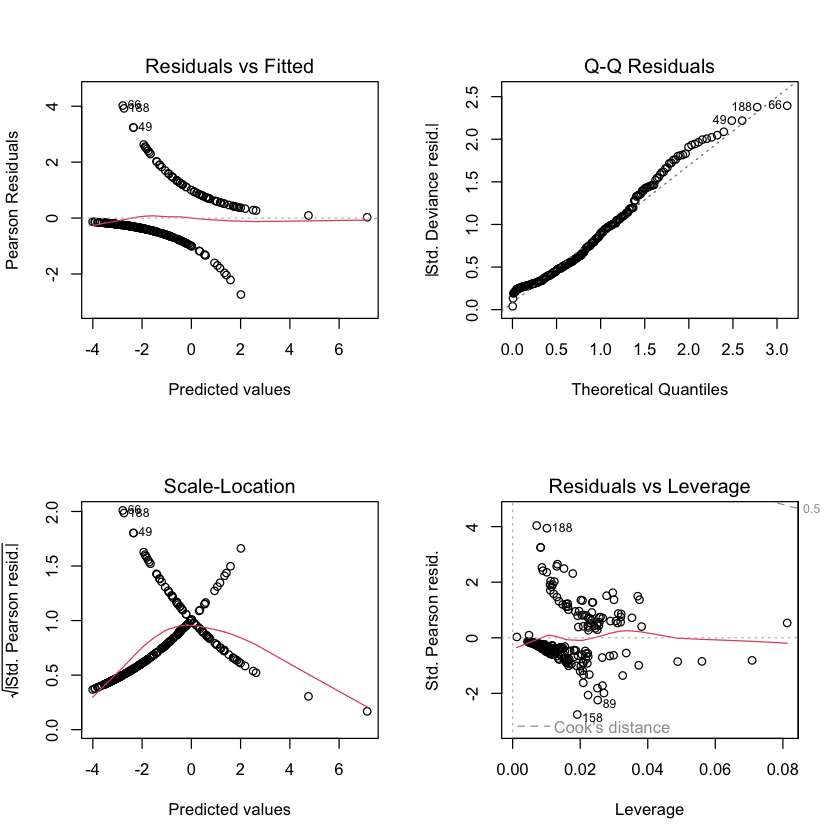

In [73]:
# para ver graficos de residuos, leverage, etc...
par(mfrow = c(2,2))
plot(modeloD)
par(mfrow = c(1,1))

Potentially influential observations of
	 glm(formula = T3DEMEN ~ AGE + WINE + MMSE, family = binomial(),      data = dataD) :

    dfb.1_ dfb.AGE dfb.WINE dfb.MMSE dffit cov.r   cook.d hat    
14  -0.13   0.07   -0.10     0.17     0.26  0.95_*  0.02   0.01  
41   0.00  -0.03   -0.10     0.08     0.21  0.95_*  0.01   0.01  
49  -0.05  -0.01   -0.08     0.15     0.23  0.93_*  0.02   0.01  
51   0.02  -0.05   -0.10     0.08     0.21  0.95_*  0.01   0.01  
55  -0.23   0.17    0.11     0.16    -0.26  1.05_*  0.01   0.05_*
66   0.08  -0.13   -0.07     0.09     0.23  0.92_*  0.03   0.01  
70   0.27  -0.25    0.10    -0.15    -0.31  1.07_*  0.01   0.07_*
110 -0.05  -0.01   -0.08     0.15     0.23  0.93_*  0.02   0.01  
118  0.23  -0.23    0.10    -0.12    -0.28  1.05_*  0.01   0.06_*
158  0.04  -0.16   -0.06     0.20    -0.32  0.96_*  0.04   0.02  
167  0.20  -0.12    0.03    -0.19     0.23  1.09_*  0.01   0.08_*
168  0.08  -0.03    0.02    -0.11     0.12  1.05_*  0.00   0.04  
188 -0.13   0.

89 158 188 
 89 158 188

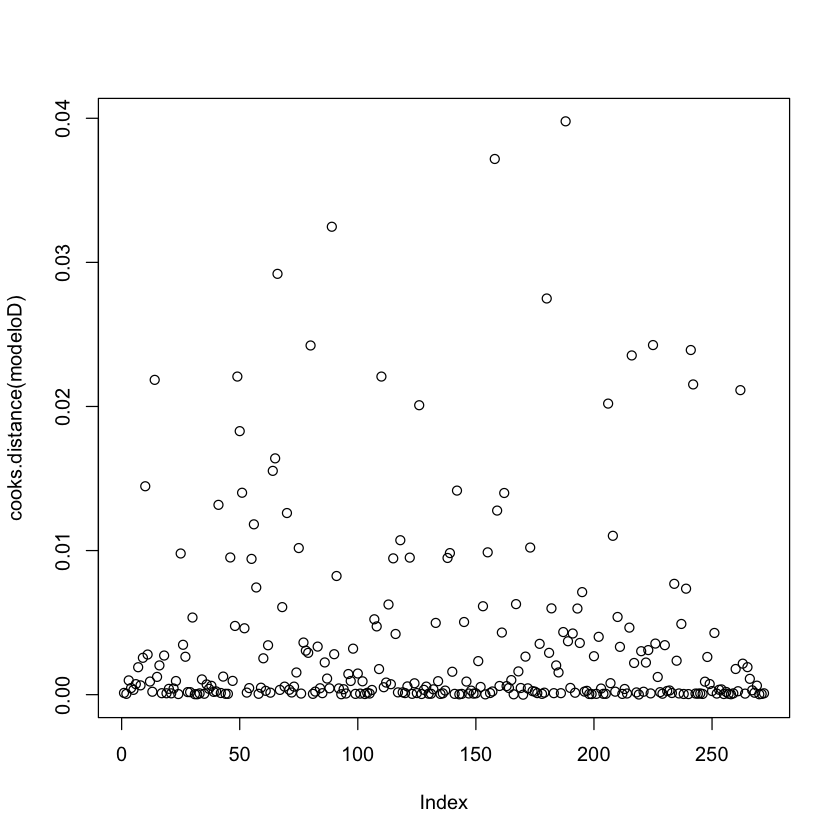

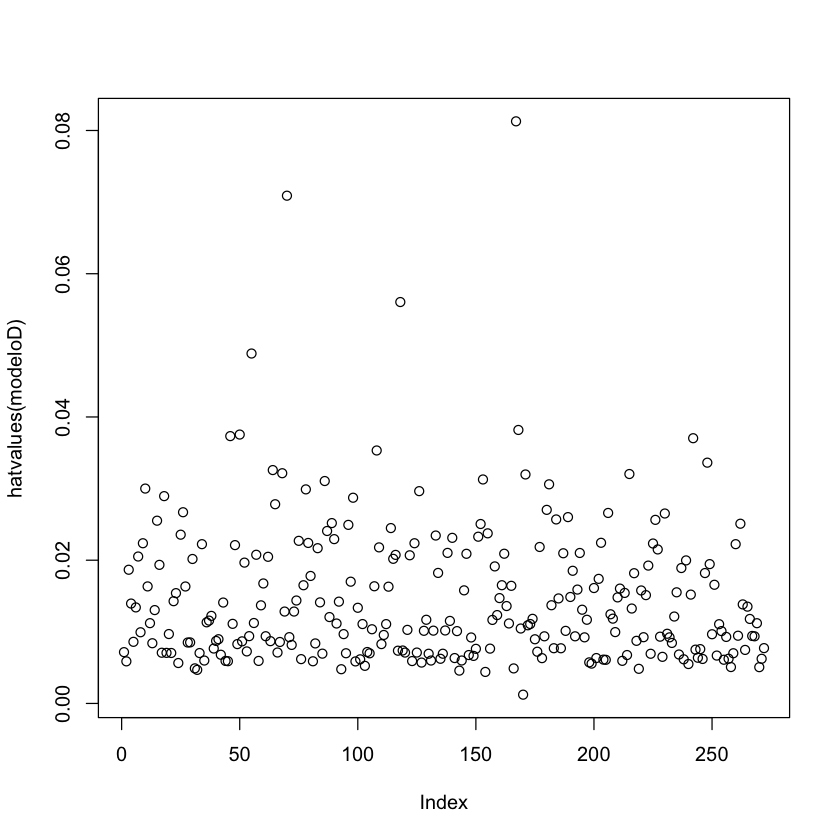

In [75]:
medidas <- influence.measures(modeloD) #da muchas medidas calculadas para cada caso.No vemos tantas...
summary(medidas)
#cooks.distance(modeloD)
plot(cooks.distance(modeloD))
which(cooks.distance(modeloD)>0.03)
plot(hatvalues(modeloD)) #son los leverages

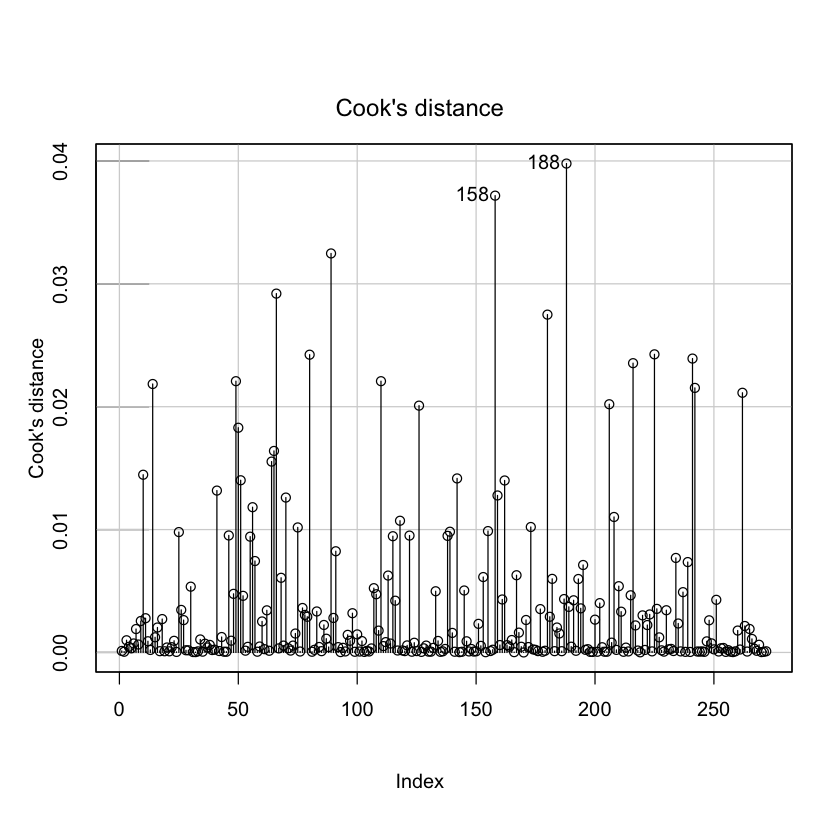

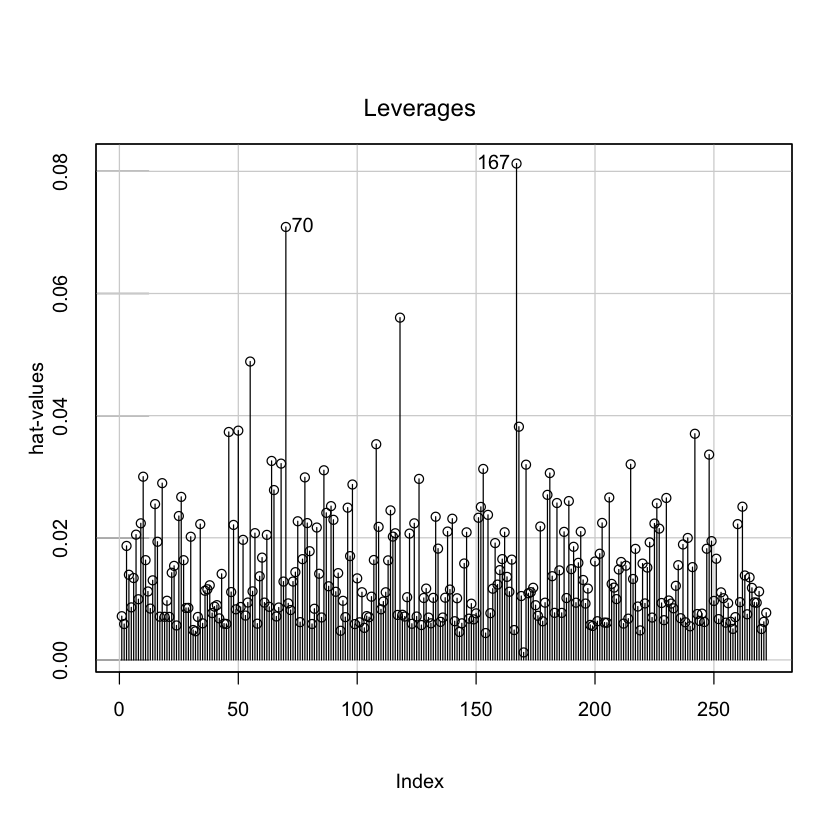

In [77]:
# otra forma:
library(car)
car::influenceIndexPlot(modeloD, vars = "Cook",
                        id=T, main = "Cook's distance")
influenceIndexPlot(modeloD, vars = "hat",
                   id=T, main = "Leverages")